# Hidden Markov Model (HMM)

In [1]:
%reload_ext autoreload
%autoreload 2

import os
import sys
sys.path.insert(0, os.path.abspath('..'))


from datasets.em_gaussian import EMGaussianDataset
from src.utils.plot import plot_clusters, plot_ellipses
from src.hidden_markov_model import HiddenMarkovModel
from src.mixture_model import MixtureModel

import matplotlib.pyplot as plt
import pandas as pd
import torch

In [2]:
x_train = EMGaussianDataset("../datasets/data/EMGaussian",train=True)[0]
x_test = EMGaussianDataset("../datasets/data/EMGaussian",train=False)[0]

hmm.pi
 [1.00000000e+00 2.54337712e-71 4.20158967e-30 1.10362925e-19]
hmm.transition_matrix
 [[0.89479978 0.03238536 0.03463037 0.06301002]
 [0.07242194 0.0226133  0.04862893 0.88109343]
 [0.01986467 0.01265677 0.88601734 0.03991441]
 [0.00678684 0.92646023 0.03937586 0.01576384]]
hmm.means
 [[-2.97260217 -3.44958263]
 [ 3.99372543  3.59102033]
 [ 3.78946956 -3.99313652]
 [-1.94809669  4.19443793]]
hmm.covariances
 [[[ 6.78104433  6.55761433]
  [ 6.55761433  6.65919718]]

 [[ 0.19777928  0.26502067]
  [ 0.26502067 12.51308687]]

 [[ 0.95270374  0.06496226]
  [ 0.06496226  1.52437108]]

 [[ 3.29324204  0.30313774]
  [ 0.30313774  2.82801456]]]


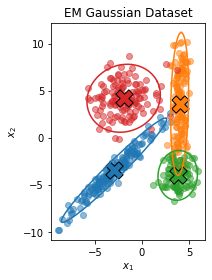

In [3]:
hmm = HiddenMarkovModel(k=4, seed=10)
hmm.initialize(x_train)
likelihoods_train, likelihoods_test = hmm.train(x_train, x_test, likelihood = True)
print("hmm.pi\n", torch.exp(hmm.pi_log).numpy())
print("hmm.transition_matrix\n", torch.exp(hmm.transition_matrix_log).numpy())
print("hmm.means\n", hmm.distribution.means.numpy())
print("hmm.covariances\n", hmm.distribution.covariances.numpy())

plot_ellipses(hmm.distribution)
hmm.distribution.predict = lambda _: hmm.predict(x_train)
plot_clusters(hmm.distribution, x_train)
plt.show()

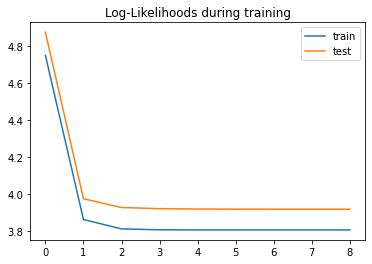

In [4]:
plt.plot(likelihoods_train, label="train")
plt.plot(likelihoods_test, label="test")
plt.legend(loc="best")
plt.title("Log-Likelihoods during training")
plt.show()

In [7]:
from src.distributions import GaussianDistribution
from functools import partial

def get_mll(models):
    data=[]
    for model_name, model_dict in models.items():
        for distribution, model in model_dict.items():
            model.initialize(x_train)
            model.train(x_train)
            data.append([model_name,
                         distribution,
                         model.normalized_negative_marginal_log_likelihood(x_train).item(),
                         model.normalized_negative_marginal_log_likelihood(x_test).item()])
    column_names=["model", "distribution", "train", "test"]
    return data, column_names


isotropic_gaussian = partial(GaussianDistribution, covariance_type='isotropic')
models = {
    "mixture_model":{
        "isotropic_gaussian":MixtureModel(4, distribution_type=isotropic_gaussian),
        "full_gaussian":MixtureModel(4),
    },
    "hidden_markov_model":{
        "isotropic_gaussian":HiddenMarkovModel(4, distribution_type=isotropic_gaussian),
        "full_gaussian":HiddenMarkovModel(4),
    }
}

data, column_names = get_mll(models)
pd.DataFrame(data, columns=column_names).round(2)

,model,distribution,train,test
0,mixture_model,isotropic_gaussian,5.30,5.33
1,mixture_model,full_gaussian,4.66,4.82
2,hidden_markov_model,isotropic_gaussian,4.64,4.50
3,hidden_markov_model,full_gaussian,3.83,3.90
